In [22]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    StateInterpolatorWithDiscreteDerivative,
)
from manipulation.station import MakeHardwareStation, load_scenario

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [29]:
hydro_bubble_gripper = "../gripper_sdfs/schunk_wsg_50_hydro_bubble.sdf"
allegro_hand = "../gripper_sdfs/allegro_hand_description_right.sdf"
model = os.path.join(os.getcwd(), allegro_hand)

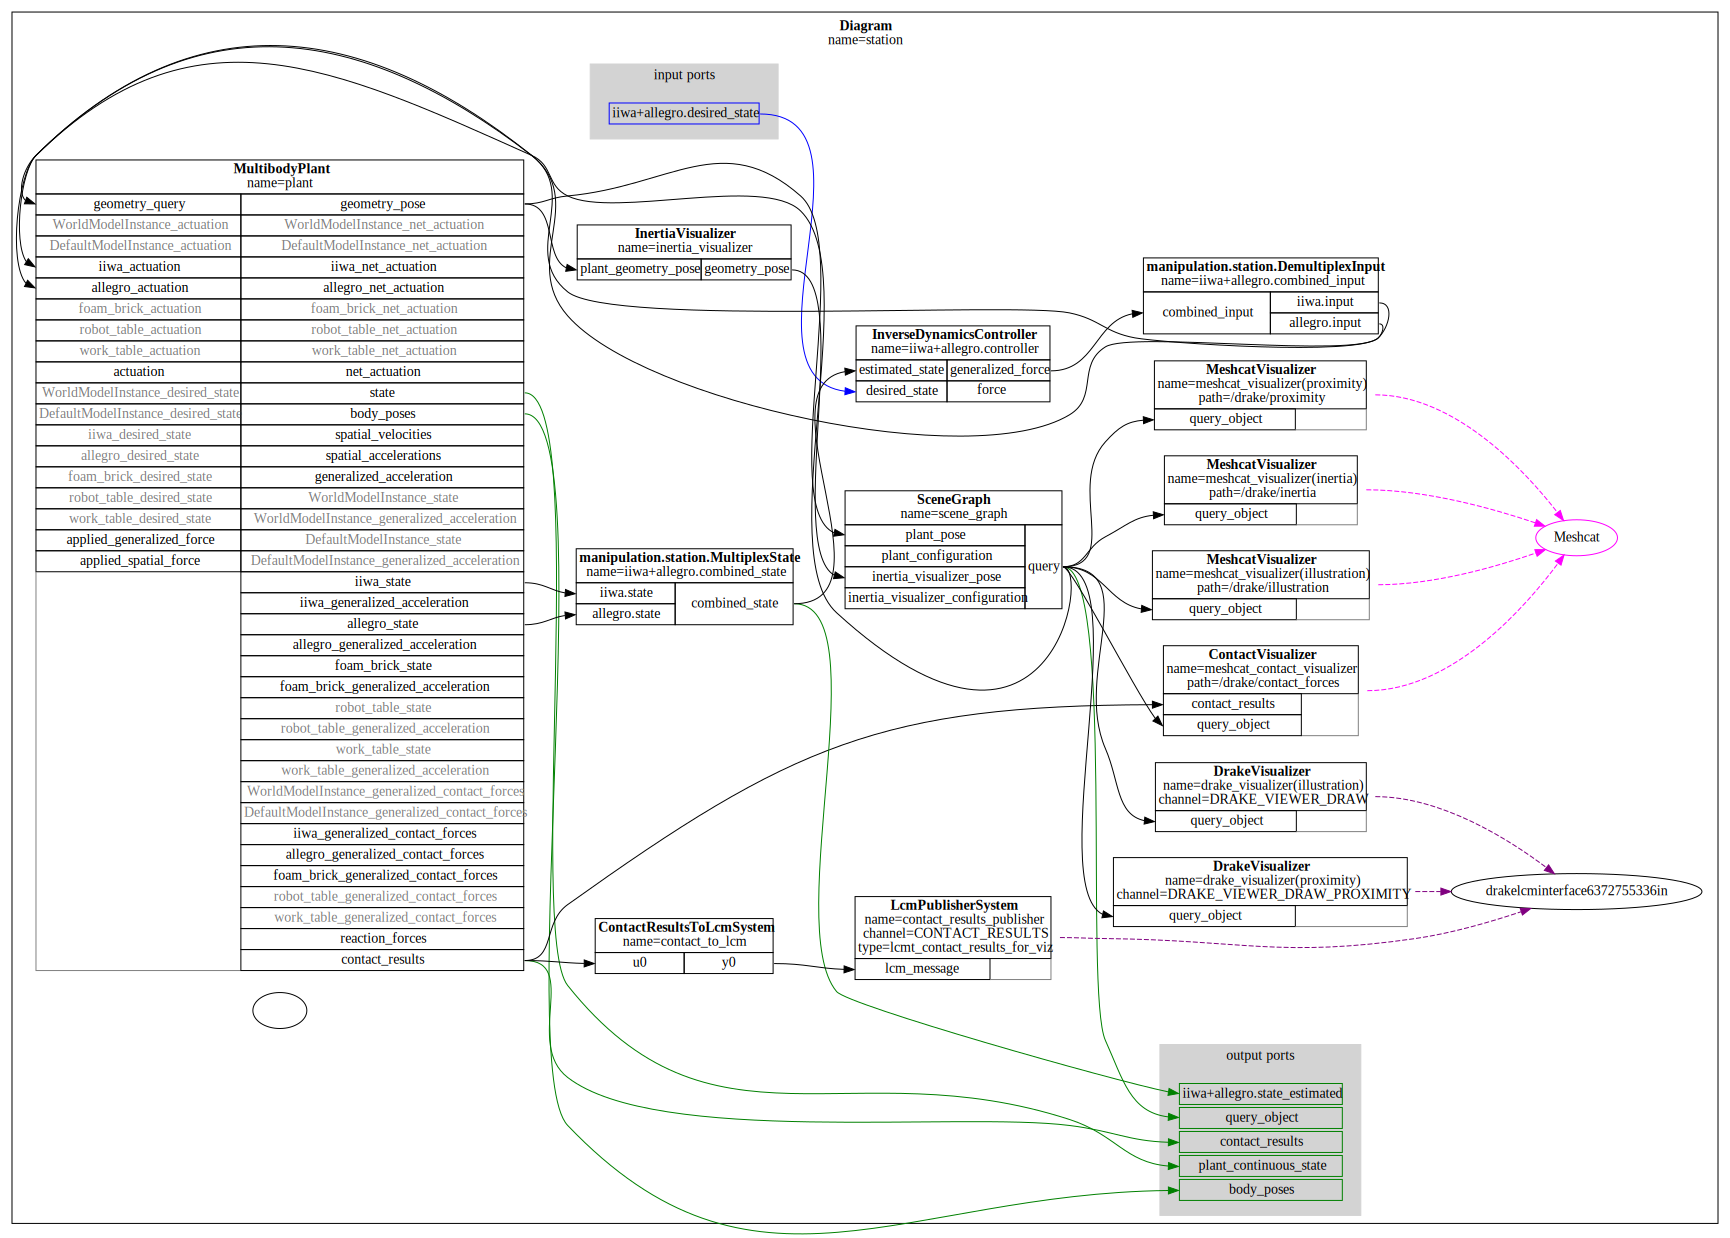

In [222]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: allegro
    file: file://""" + model + """
- add_weld:
    parent: iiwa::iiwa_link_7
    child: allegro::hand_root
    X_PC:
        translation: [0, 0, 0.05]
        rotation: !Rpy { deg: [0, 0, 0]}
# And now the environment:
- add_model:
    name: foam_brick
    file: package://drake/examples/manipulation_station/models/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.6, 0, 0]
- add_model:
    name: robot_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.7645]
- add_model:
    name: work_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.7645]
model_drivers:
    iiwa+allegro: !InverseDynamicsDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat)

display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

simulator = Simulator(station)
context = simulator.get_mutable_context()

x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)

# Confirm that simulation works:
simulator.AdvanceTo(0.1)

In [163]:
plant = station.GetSubsystemByName("plant")

In [164]:
time = 0.2


In [165]:
def open_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[iiwa_idx:] = current_state[iiwa_idx] * -1
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [166]:
def close_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[iiwa_idx:] = 4
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [207]:
def close_finger(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[20:] = 4
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [209]:
close_finger(station, context)
simulator.AdvanceTo(time)
time += .1

In [206]:
open_hand(station, context)
simulator.AdvanceTo(time)
time += .1

In [203]:
close_hand(station, context)
simulator.AdvanceTo(time)
time += .1

In [199]:
plant.get_contact_model()

<ContactModel.kHydroelasticWithFallback: 2>

In [221]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
print(num_contacts)
a = contact.point_pair_contact_info(num_contacts - 1)
a.contact_force()

10


array([-2.78832199e-06, -2.77532879e-06, -6.86756179e-02])